In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from einops import rearrange
import math


In [46]:
# === Embedding of Time Step with Random Fourier Features ===
class TimeFourierEmbedding(nn.Module):
    def __init__(self, embedding_dim, scale=30.):
        super().__init__()
        self.register_buffer('weight', torch.randn(embedding_dim // 2) * scale)

    def forward(self, t):
        # t: [batch_size]
        proj = t[:, None] * self.weight[None, :] * 2 * np.pi
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)

In [47]:
# === Helper Dense layer for time conditioning broadcast ===
class TimeConditioningDense(nn.Module):
    def __init__(self, input_dim, output_channels):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_channels)

    def forward(self, x):
        # Output shaped for broadcasting over spatial dims
        return self.linear(x)[..., None, None]

In [92]:
def marginal_std(t, beta_min=0.1, beta_max=20.0):
    t = t.clone().detach().to(device)
    beta_t = beta_min + t * (beta_max - beta_min)
    alpha_t = torch.cos((t + 0.008) / 1.008 * np.pi / 2) ** 2
    return torch.sqrt(1 - alpha_t)
def diffusion_coefficient(t, beta_min=0.1, beta_max=20.0):
    beta_t = beta_min + t * (beta_max - beta_min)
    return torch.sqrt(beta_t)

marginal_std_fn = functools.partial(marginal_std, beta_min=0.1, beta_max=20.0)
diffusion_coeff_fn = functools.partial(diffusion_coefficient, beta_min=0.1, beta_max=20.0)

In [51]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
        self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.embed_dim = embed_dim

    def forward(self, tokens):
        Q = self.query(tokens)
        K = self.key(tokens)
        V = self.value(tokens)
        scores = torch.einsum("BTH,BSH->BTS", Q, K) / math.sqrt(self.embed_dim)
        attn = torch.softmax(scores, dim=-1)
        return torch.einsum("BTS,BSH->BTH", attn, V)

In [52]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim):
        super().__init__()
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        self.key = nn.Linear(context_dim, embed_dim, bias=False)
        self.value = nn.Linear(context_dim, hidden_dim, bias=False)
        self.embed_dim = embed_dim

    def forward(self, tokens, context):
        Q = self.query(tokens)
        K = self.key(context)
        V = self.value(context)
        scores = torch.einsum("BTH,BSH->BTS", Q, K) / math.sqrt(self.embed_dim)
        attn = torch.softmax(scores, dim=-1)
        return torch.einsum("BTS,BSH->BTH", attn, V)

In [53]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        super().__init__()
        self.attn_self = SelfAttention(embed_dim=hidden_dim, hidden_dim=hidden_dim)
        self.attn_cross = CrossAttention(embed_dim=hidden_dim, hidden_dim=hidden_dim, context_dim=context_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        x = self.attn_self(self.norm1(x)) + x
        x = self.attn_cross(self.norm2(x), context=context) + x
        x = self.ffn(self.norm3(x)) + x
        return x


In [54]:
# === Spatial Transformer that reshapes CNN features for transformer blocks ===
class SpatialTransformerBlock(nn.Module):
    def __init__(self, channel_dim, context_dim):
        super().__init__()
        self.transformer = TransformerBlock(channel_dim, context_dim)

    def forward(self, feature_map, context=None):
        batch_size, channels, height, width = feature_map.shape
        x = rearrange(feature_map, 'b c h w -> b (h w) c')
        x = self.transformer(x, context)
        x = rearrange(x, 'b (h w) c -> b c h w', h=height, w=width)
        return x + feature_map

In [55]:
# === Conditional UNet with Transformer attention layers for score estimation ===
class ConditionalScoreUNet(nn.Module):
    def __init__(self, marginal_std_func, channels=[32, 64, 128, 256], time_embed_dim=256, cond_embed_dim=256, num_classes=10):
        super().__init__()
        self.marginal_std_func = marginal_std_func

        # Time embedding
        self.time_embedding = nn.Sequential(
            TimeFourierEmbedding(embedding_dim=time_embed_dim),
            nn.Linear(time_embed_dim, time_embed_dim)
        )
        self.activation = nn.SiLU()

        # Input conv layers
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=3, stride=1, bias=False)
        self.time_dense1 = TimeConditioningDense(time_embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.time_dense2 = TimeConditioningDense(time_embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.time_dense3 = TimeConditioningDense(time_embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, channels[2])
        self.attn3 = SpatialTransformerBlock(channels[2], cond_embed_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.time_dense4 = TimeConditioningDense(time_embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, channels[3])
        self.attn4 = SpatialTransformerBlock(channels[3], cond_embed_dim)

        # Decoder layers (transpose conv)
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.time_dense5 = TimeConditioningDense(time_embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.time_dense6 = TimeConditioningDense(time_embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.time_dense7 = TimeConditioningDense(time_embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # Embedding for conditioning (class labels)
        self.class_embedding = nn.Embedding(num_classes, cond_embed_dim)

    def forward(self, x, t, class_labels=None):
        time_emb = self.activation(self.time_embedding(t))
        cond_emb = self.class_embedding(class_labels).unsqueeze(1)  # (B, 1, cond_embed_dim)

        h1 = self.conv1(x) + self.time_dense1(time_emb)
        h1 = self.activation(self.gnorm1(h1))

        h2 = self.conv2(h1) + self.time_dense2(time_emb)
        h2 = self.activation(self.gnorm2(h2))

        h3 = self.conv3(h2) + self.time_dense3(time_emb)
        h3 = self.activation(self.gnorm3(h3))
        h3 = self.attn3(h3, cond_emb)

        h4 = self.conv4(h3) + self.time_dense4(time_emb)
        h4 = self.activation(self.gnorm4(h4))
        h4 = self.attn4(h4, cond_emb)

        h = self.tconv4(h4) + self.time_dense5(time_emb)
        h = self.activation(self.tgnorm4(h))

        h = self.tconv3(h + h3) + self.time_dense6(time_emb)
        h = self.activation(self.tgnorm3(h))

        h = self.tconv2(h + h2) + self.time_dense7(time_emb)
        h = self.activation(self.tgnorm2(h))

        h = self.tconv1(h + h1)

        # Normalize output by marginal std at t
        h = h / self.marginal_std_func(t)[:, None, None, None]
        return h

In [56]:
# === Euler-Maruyama sampler for reverse diffusion ===
def euler_maruyama_sampler(score_model, marginal_std_fn, diffusion_coeff_fn, batch_size=64,
                           img_shape=(1, 28, 28), num_steps=500, device='cuda', eps=1e-3,
                           class_labels=None, save_intermediate=False):
    t = torch.ones(batch_size, device=device)
    init_noise = torch.randn(batch_size, *img_shape, device=device) * marginal_std_fn(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_noise
    intermediate_images = [] if save_intermediate else None

    with torch.no_grad():
        for time_step in tqdm.tqdm(time_steps):
            current_t = torch.full((batch_size,), time_step.item(), device=device)
            g = diffusion_coeff_fn(current_t)
            score = score_model(x, current_t, class_labels)
            mean_x = x + (g ** 2)[:, None, None, None] * score * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

            if save_intermediate and time_step in time_steps[::num_steps // 10]:
                intermediate_images.append(x.clamp(0.0, 1.0))

    return mean_x, intermediate_images

In [57]:
# === Loss function for conditional score matching ===
def conditional_score_loss(model, images, labels, marginal_std_fn, eps=1e-5):
    batch_size = images.shape[0]
    t = torch.rand(batch_size, device=images.device) * (1 - eps) + eps
    noise = torch.randn_like(images)
    std = marginal_std_fn(t)
    noisy_images = images + noise * std[:, None, None, None]
    score = model(noisy_images, t, labels)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + noise) ** 2, dim=[1, 2, 3]))
    return loss

In [58]:
# === Setup device ===
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# === Instantiate model, optimizer, dataloader ===
score_net = nn.DataParallel(ConditionalScoreUNet(marginal_std_func=marginal_std_fn))
score_net.to(device)

In [84]:

num_epochs = 100
batch_size = 1024
learning_rate = 1e-3

In [85]:
mnist_dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [86]:
optimizer = Adam(score_net.parameters(), lr=learning_rate)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

In [87]:
# === Training loop ===
for epoch in trange(num_epochs, desc="Training epochs"):
    total_loss = 0
    total_samples = 0
    for images, labels in mnist_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        loss = conditional_score_loss(score_net, images, labels, marginal_std_fn)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.shape[0]
        total_samples += images.shape[0]

    scheduler.step()
    avg_loss = total_loss / total_samples
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.5f} - LR: {current_lr:.1e}")

Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 74.66469 - LR: 9.8e-04
Epoch 2 - Average Loss: 38.98317 - LR: 9.6e-04
Epoch 3 - Average Loss: 37.21246 - LR: 9.4e-04
Epoch 4 - Average Loss: 36.78009 - LR: 9.2e-04
Epoch 5 - Average Loss: 37.00726 - LR: 9.0e-04
Epoch 6 - Average Loss: 36.85041 - LR: 8.9e-04
Epoch 7 - Average Loss: 36.33515 - LR: 8.7e-04
Epoch 8 - Average Loss: 36.04607 - LR: 8.5e-04
Epoch 9 - Average Loss: 36.65161 - LR: 8.3e-04
Epoch 10 - Average Loss: 36.12011 - LR: 8.2e-04
Epoch 11 - Average Loss: 35.82446 - LR: 8.0e-04
Epoch 12 - Average Loss: 35.84518 - LR: 7.8e-04
Epoch 13 - Average Loss: 35.86941 - LR: 7.7e-04
Epoch 14 - Average Loss: 35.47716 - LR: 7.5e-04
Epoch 15 - Average Loss: 35.75661 - LR: 7.4e-04
Epoch 16 - Average Loss: 35.55701 - LR: 7.2e-04
Epoch 17 - Average Loss: 35.50356 - LR: 7.1e-04
Epoch 18 - Average Loss: 35.35469 - LR: 7.0e-04
Epoch 19 - Average Loss: 35.53145 - LR: 6.8e-04
Epoch 20 - Average Loss: 35.51883 - LR: 6.7e-04
Epoch 21 - Average Loss: 34.96062 - LR: 6.5e-04
E

In [88]:
# === Save trained model ===
torch.save(score_net.state_dict(), 'conditional_score_unet.pth')

In [89]:
# === Load saved model for inference ===
checkpoint = torch.load('conditional_score_unet.pth', map_location=device)
score_net.load_state_dict(checkpoint)

<All keys matched successfully>

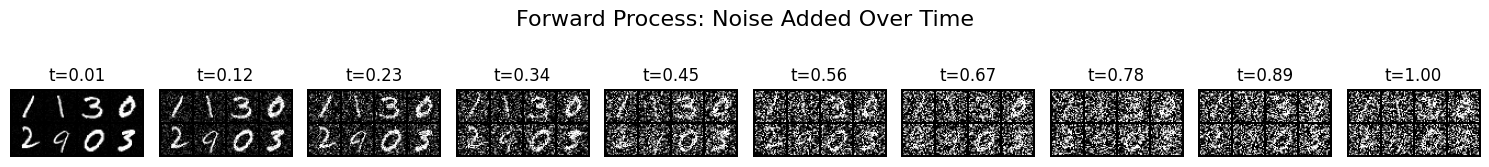

In [78]:
# === Visualize Forward Diffusion Process ===
x_real, _ = next(iter(mnist_loader))
x_real = x_real[:8].to(device)
timesteps = torch.linspace(0.01, 1.0, 10).to(device)

plt.figure(figsize=(15, 2))
for i, t in enumerate(timesteps):
    std = marginal_std_fn(t)
    noisy_imgs = x_real + std * torch.randn_like(x_real)
    img_grid = make_grid(noisy_imgs, nrow=4).permute(1, 2, 0).cpu().clamp(0, 1)
    plt.subplot(1, 10, i + 1)
    plt.imshow(img_grid, cmap='gray')
    plt.title(f't={t.item():.2f}')
    plt.axis('off')
plt.suptitle("Forward Process: Noise Added Over Time", fontsize=16)
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:02<00:00, 183.33it/s]


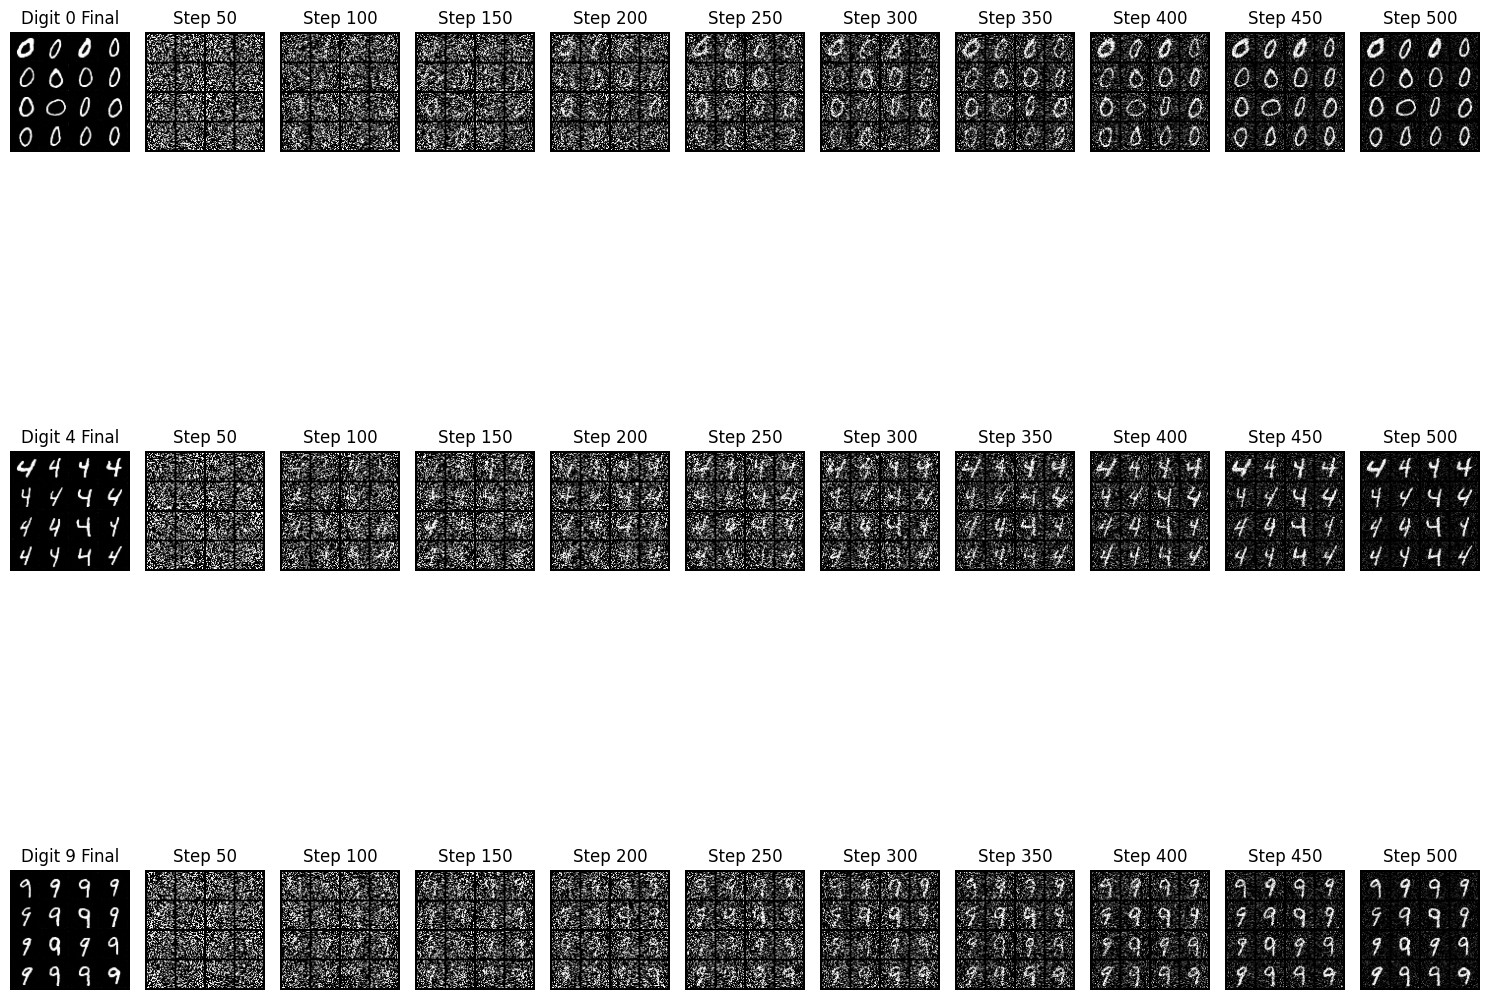

In [91]:

# === Generate Samples Conditioned on Different Digits ===
target_digits = [0, 4, 9]
sample_batch_size = 16
num_sampling_steps = 500

plt.figure(figsize=(15, 5 * len(target_digits)))
for idx, digit in enumerate(target_digits, 1):
    class_tensor = digit * torch.ones(sample_batch_size, dtype=torch.long, device=device)
    final_samples, intermediate_imgs = euler_maruyama_sampler(
        score_net, marginal_std_fn, diffusion_coeff_fn, sample_batch_size,
        num_steps=num_sampling_steps, device=device,
        class_labels=class_tensor, save_intermediate=True
    )
    final_samples = final_samples.clamp(0.0, 1.0)
    grid = make_grid(final_samples, nrow=4)

    plt.subplot(len(target_digits), 11, idx * 11 - 10)
    plt.imshow(grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.title(f'Digit {digit} Final')
    plt.axis('off')

    for i, intermediate_img in enumerate(intermediate_imgs):
        inter_grid = make_grid(intermediate_img, nrow=4)
        plt.subplot(len(target_digits), 11, idx * 11 - 10 + i + 1)
        plt.imshow(inter_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
        plt.title(f'Step {(i + 1) * num_sampling_steps // 10}')
        plt.axis('off')

plt.tight_layout()
plt.show()


100%|██████████| 500/500 [00:03<00:00, 156.99it/s]


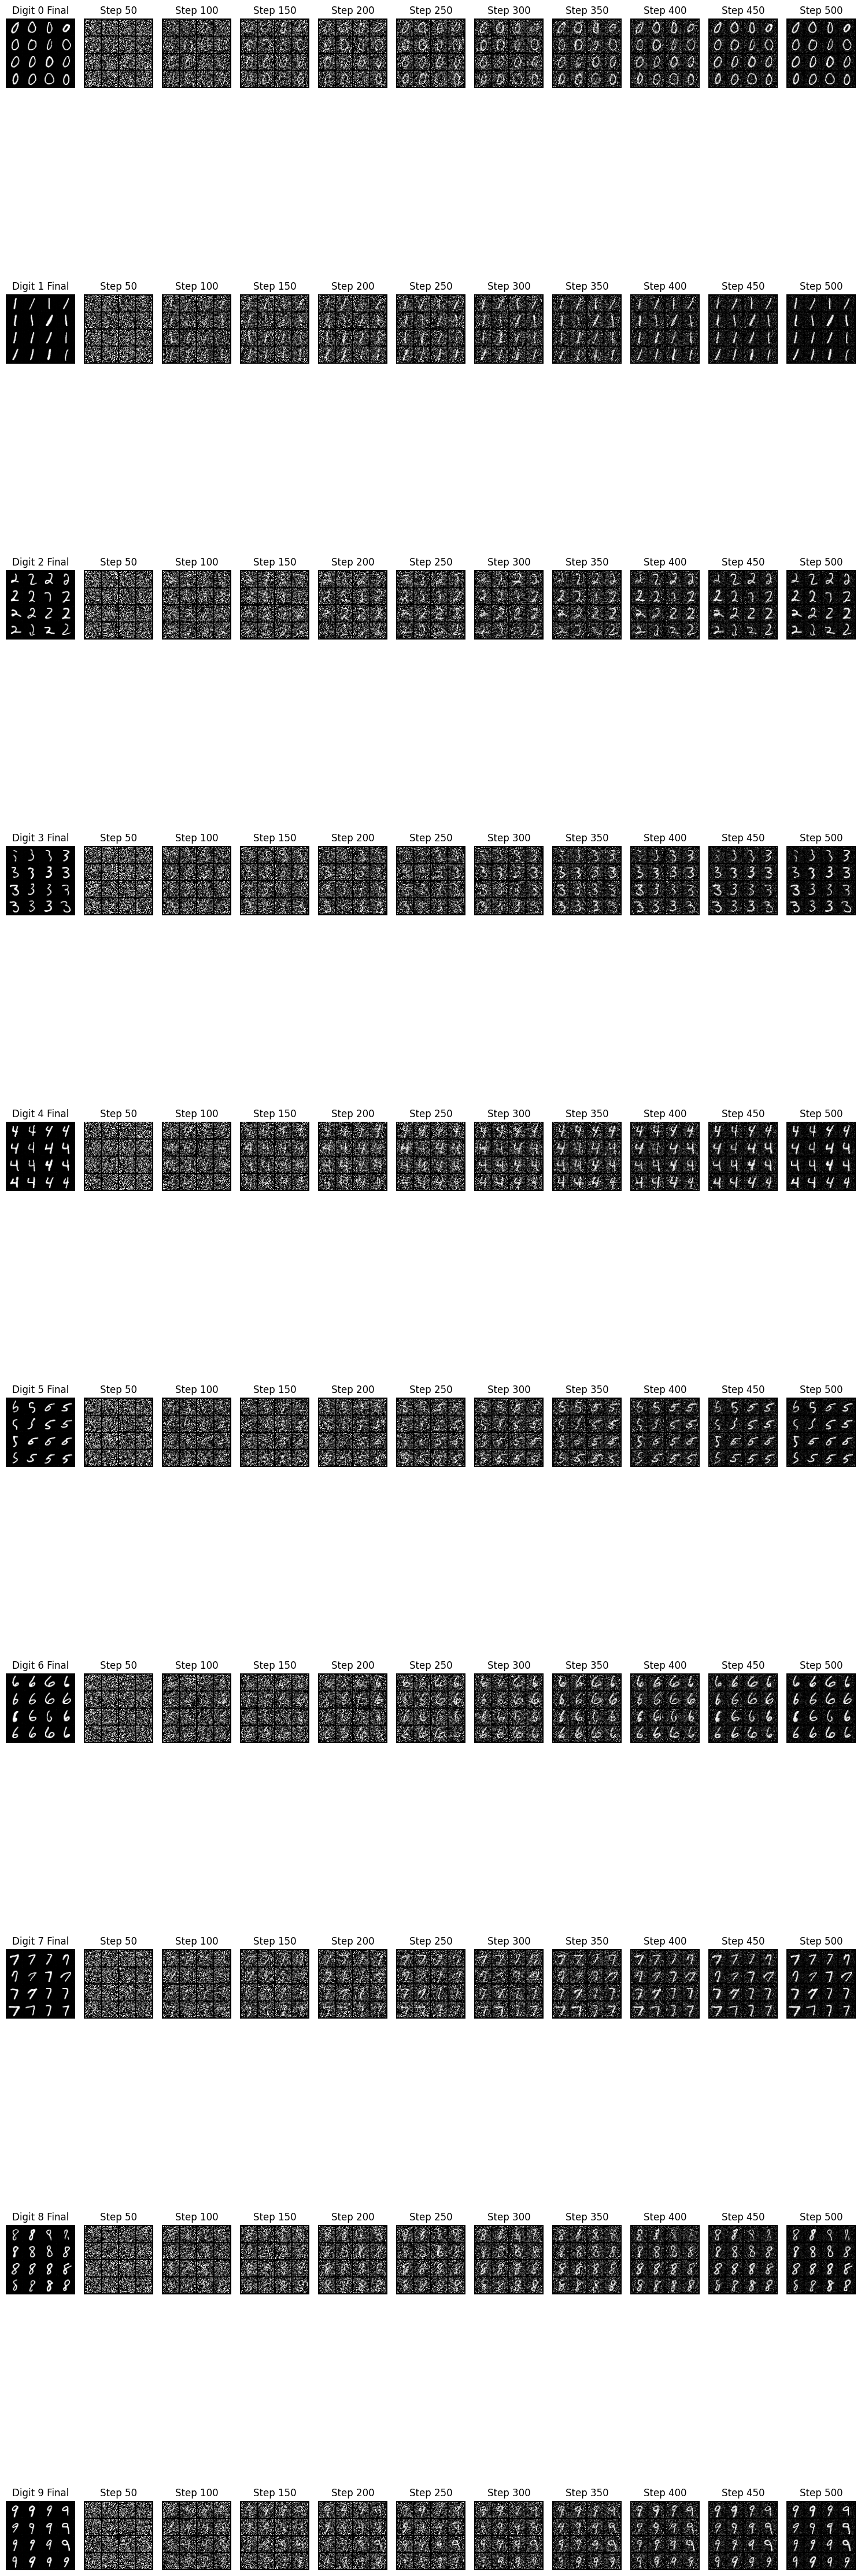

In [97]:
# === Generate Samples Conditioned on Different Digits ===
target_digits = list(range(10))
sample_batch_size = 16
num_sampling_steps = 500

plt.figure(figsize=(15, 5 * len(target_digits)))
for idx, digit in enumerate(target_digits):
    class_tensor = digit * torch.ones(sample_batch_size, dtype=torch.long, device=device)
    final_samples, intermediate_imgs = euler_maruyama_sampler(
        score_net, marginal_std_fn, diffusion_coeff_fn, sample_batch_size,
        num_steps=num_sampling_steps, device=device,
        class_labels=class_tensor, save_intermediate=True
    )
    final_samples = final_samples.clamp(0.0, 1.0)
    grid = make_grid(final_samples, nrow=4)

    plt.subplot(len(target_digits), 11, idx * 11 + 1)  # corrected here
    plt.imshow(grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.title(f'Digit {digit} Final')
    plt.axis('off')

    for i, intermediate_img in enumerate(intermediate_imgs):
        inter_grid = make_grid(intermediate_img, nrow=4)
        plt.subplot(len(target_digits), 11, idx * 11 + 2 + i)  # corrected here
        plt.imshow(inter_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
        plt.title(f'Step {(i + 1) * num_sampling_steps // 10}')
        plt.axis('off')

plt.tight_layout()
plt.show()